Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
from torch.utils.data import Dataset, DataLoader
import warnings
import itertools
warnings.filterwarnings('ignore')

Load the dataset

In [2]:
df = pd.read_csv('/home/ducanh/Credit Card Transactions Fraud Detection/Datasets/fraudTrain.csv')
print(df.head())
print(df.info())

   Unnamed: 0 trans_date_trans_time            cc_num  \
0           0   2019-01-01 00:00:18  2703186189652095   
1           1   2019-01-01 00:00:44      630423337322   
2           2   2019-01-01 00:00:51    38859492057661   
3           3   2019-01-01 00:01:16  3534093764340240   
4           4   2019-01-01 00:03:06   375534208663984   

                             merchant       category     amt      first  \
0          fraud_Rippin, Kub and Mann       misc_net    4.97   Jennifer   
1     fraud_Heller, Gutmann and Zieme    grocery_pos  107.23  Stephanie   
2                fraud_Lind-Buckridge  entertainment  220.11     Edward   
3  fraud_Kutch, Hermiston and Farrell  gas_transport   45.00     Jeremy   
4                 fraud_Keeling-Crist       misc_pos   41.96      Tyler   

      last gender                        street  ...      lat      long  \
0    Banks      F                561 Perry Cove  ...  36.0788  -81.1781   
1     Gill      F  43039 Riley Greens Suite 393  ...  48

In [3]:
print(f"Number of duplicated transactions: {df['trans_num'].duplicated().sum()}")
print(f"Number of unique cardholders: {len(df['cc_num'].unique())}")
print("\nSummary Statistics:")
print(df.describe())

Number of duplicated transactions: 0
Number of unique cardholders: 983

Summary Statistics:
         Unnamed: 0        cc_num           amt           zip           lat  \
count  1.296675e+06  1.296675e+06  1.296675e+06  1.296675e+06  1.296675e+06   
mean   6.483370e+05  4.171920e+17  7.035104e+01  4.880067e+04  3.853762e+01   
std    3.743180e+05  1.308806e+18  1.603160e+02  2.689322e+04  5.075808e+00   
min    0.000000e+00  6.041621e+10  1.000000e+00  1.257000e+03  2.002710e+01   
25%    3.241685e+05  1.800429e+14  9.650000e+00  2.623700e+04  3.462050e+01   
50%    6.483370e+05  3.521417e+15  4.752000e+01  4.817400e+04  3.935430e+01   
75%    9.725055e+05  4.642255e+15  8.314000e+01  7.204200e+04  4.194040e+01   
max    1.296674e+06  4.992346e+18  2.894890e+04  9.978300e+04  6.669330e+01   

               long      city_pop     unix_time     merch_lat    merch_long  \
count  1.296675e+06  1.296675e+06  1.296675e+06  1.296675e+06  1.296675e+06   
mean  -9.022634e+01  8.882444e+04  1.3

Visualize fraud vs non-fraud transactions

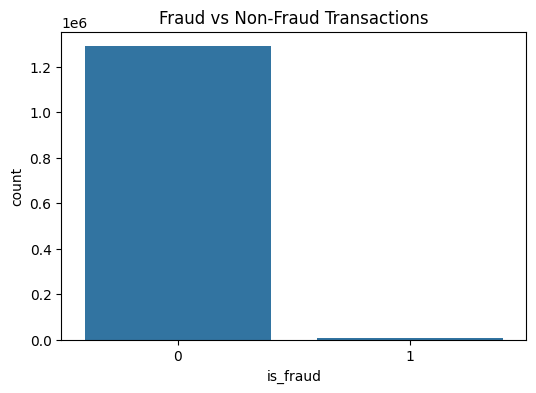

In [4]:
plt.figure(figsize=(6, 4))
sns.countplot(x='is_fraud', data=df)
plt.title('Fraud vs Non-Fraud Transactions')
plt.show()

Calculate and display fraud statistics

In [5]:
fraud_count = df['is_fraud'].value_counts()
non_fraud_count = fraud_count[0]
fraud_transactions = fraud_count[1]
print(f"Number of non-fraud transactions: {non_fraud_count}")
print(f"Number of fraud transactions: {fraud_transactions}")

Number of non-fraud transactions: 1289169
Number of fraud transactions: 7506


In [6]:
total_transactions = len(df)
non_fraud_rate = (non_fraud_count / total_transactions) * 100
fraud_rate = (fraud_transactions / total_transactions) * 100
print(f"Rate of non-fraud transactions: {non_fraud_rate:.2f}%")
print(f"Rate of fraud transactions: {fraud_rate:.2f}%")

Rate of non-fraud transactions: 99.42%
Rate of fraud transactions: 0.58%


Visualize transaction amount distribution

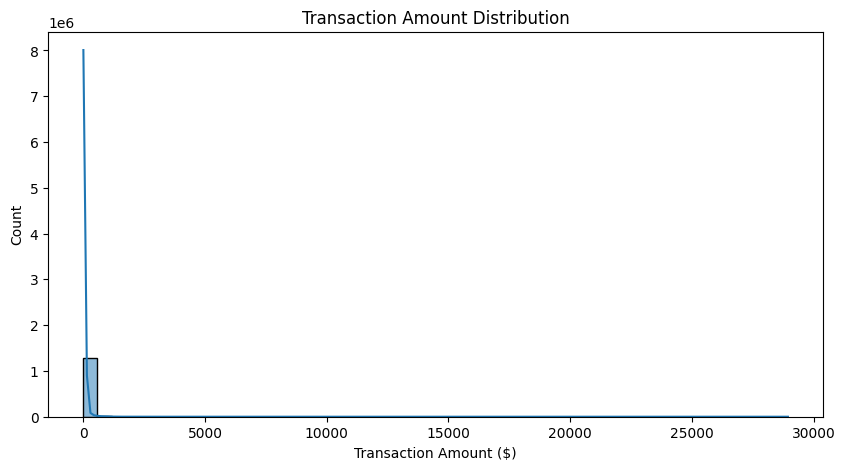

In [7]:
plt.figure(figsize=(10, 5))
sns.histplot(df['amt'], bins=50, kde=True)
plt.title('Transaction Amount Distribution')
plt.xlabel('Transaction Amount ($)')
plt.show()

KDE plot for fraudulent vs non-fraudulent transactions

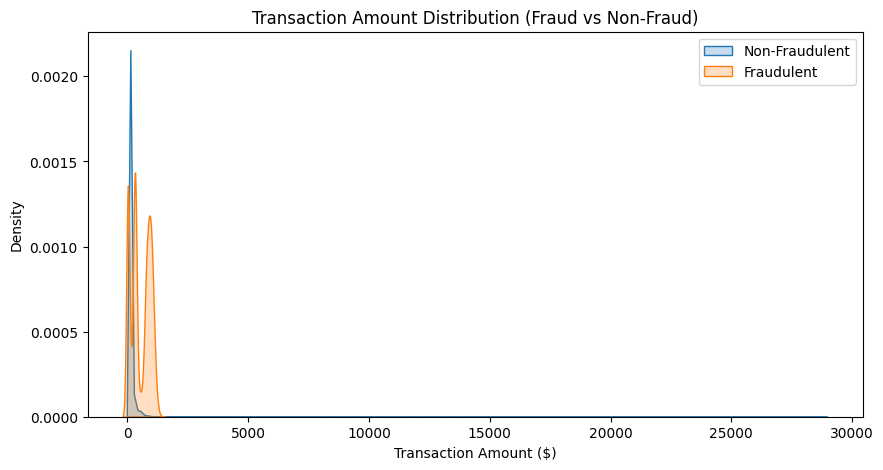

In [8]:
plt.figure(figsize=(10, 5))
sns.kdeplot(df[df['is_fraud'] == 0]['amt'], label='Non-Fraudulent', shade=True)
sns.kdeplot(df[df['is_fraud'] == 1]['amt'], label='Fraudulent', shade=True)
plt.title('Transaction Amount Distribution (Fraud vs Non-Fraud)')
plt.xlabel('Transaction Amount ($)')
plt.legend()
plt.show()

Handle 'dob' column if present

In [9]:
if 'dob' in df.columns:
    df['dob'] = pd.to_datetime(df['dob'], errors='coerce')
    df['cust_age'] = 2025 - df['dob'].dt.year

Correlation heatmap for numeric columns

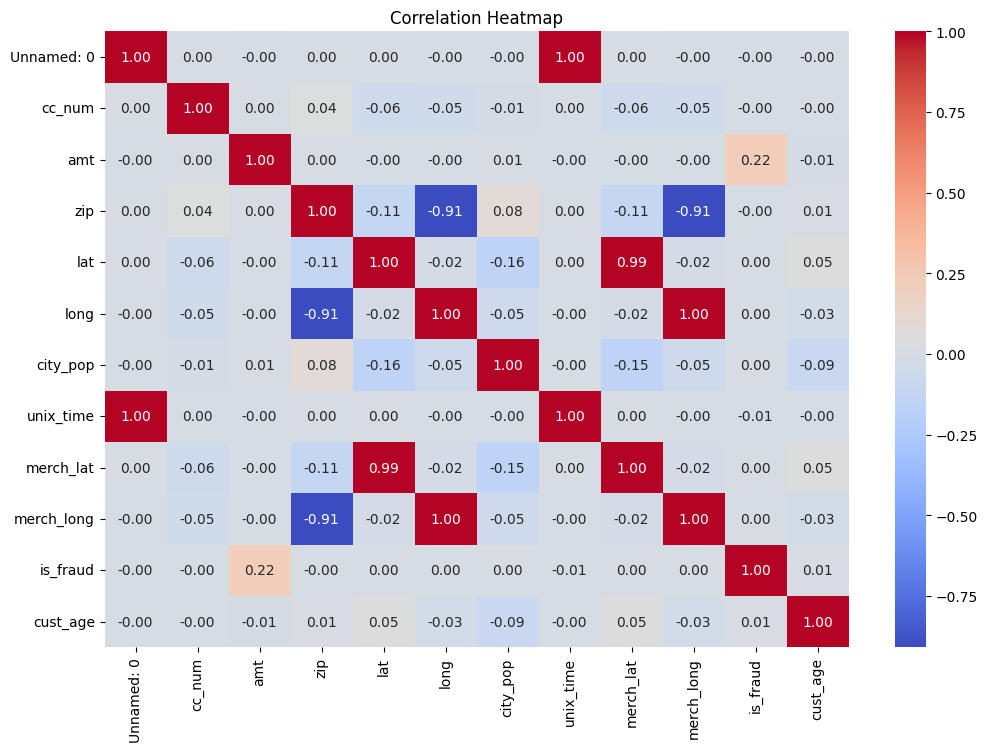

In [10]:
numeric_df = df.select_dtypes(include=['number'])
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

Prepare data for training

In [11]:
X = df.drop('is_fraud', axis=1)
y = df['is_fraud']

Split data into training and testing sets

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

Drop irrelevant columns

In [13]:
drop_cols = ['ssn', 'first', 'last', 'street', 'city', 'state', 'profile', 'trans_num', 'dob', 'trans_date_trans_time']
X_train.drop(columns=drop_cols, errors='ignore', inplace=True)
X_test.drop(columns=drop_cols, errors='ignore', inplace=True)

Encode categorical columns

In [14]:
categorical_cols = ['gender', 'job', 'category', 'merchant']
for col in categorical_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))

Standardize numerical features

In [15]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

X_train_sc = pd.DataFrame(X_train_sc, columns=X_train.columns)
X_test_sc = pd.DataFrame(X_test_sc, columns=X_test.columns)

Logistic Regression

In [16]:
print("\n---- Logistic Regression ----")
lr = LogisticRegression(class_weight='balanced')
lr.fit(X_train_sc, y_train)


---- Logistic Regression ----


LogisticRegression(class_weight='balanced')

Evaluate Logistic Regression

In [17]:
y_train_pred_lr = lr.predict(X_train_sc)
y_test_pred_lr = lr.predict(X_test_sc)
print(f'Recall Score on Train Data: {recall_score(y_train, y_train_pred_lr)}')
print(f'Recall Score on Test Data: {recall_score(y_test, y_test_pred_lr)}')

Recall Score on Train Data: 0.7536289520779479
Recall Score on Test Data: 0.7723052079127978


Feature importance for Logistic Regression

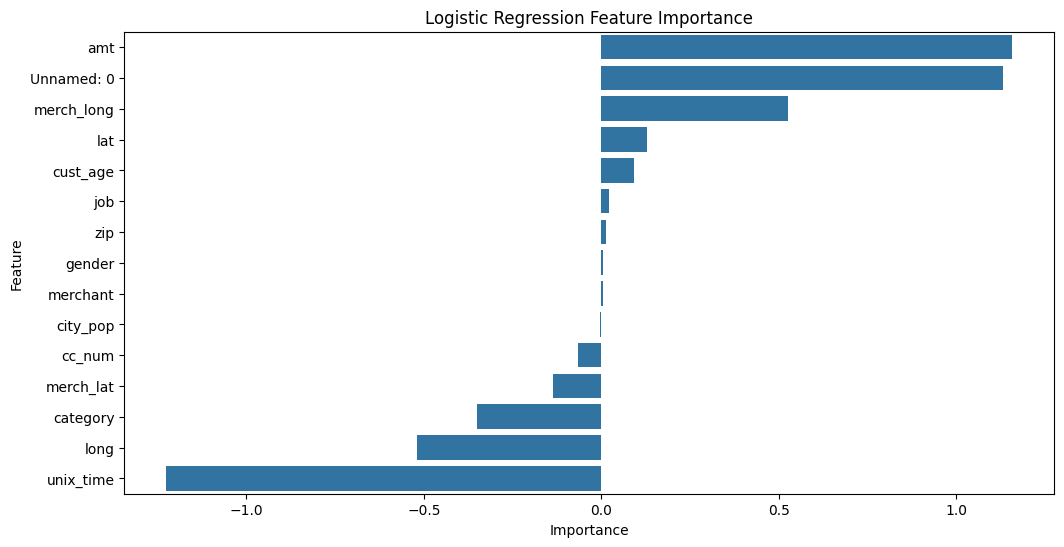

In [18]:
coefficients = pd.DataFrame({'Feature': X_train.columns, 'Importance': lr.coef_.flatten()})
coefficients.sort_values(by='Importance', ascending=False, inplace=True)
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=coefficients)
plt.title('Logistic Regression Feature Importance')
plt.show()

Random Forest

In [19]:
print("\n---- Random Forest ----")
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf.fit(X_train_sc, y_train)
y_train_pred_rf = rf.predict(X_train_sc)
y_test_pred_rf = rf.predict(X_test_sc)


---- Random Forest ----


Evaluate Random Forest

In [20]:
print(f'Recall Score on Train Data: {recall_score(y_train, y_train_pred_rf)}')
print(f'Recall Score on Test Data: {recall_score(y_test, y_test_pred_rf)}')

Recall Score on Train Data: 0.9998011533107973
Recall Score on Test Data: 0.6322163907953169


Feature importance for Random Forest

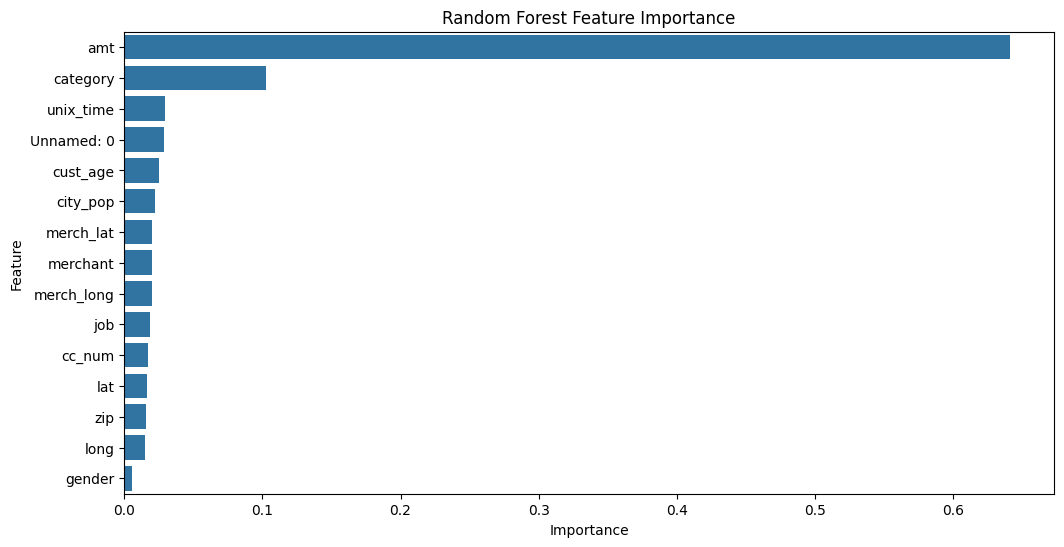

In [21]:
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': rf.feature_importances_})
feature_importances.sort_values(by='Importance', ascending=False, inplace=True)
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Random Forest Feature Importance')
plt.show()

In [23]:
from sklearn.metrics import confusion_matrix

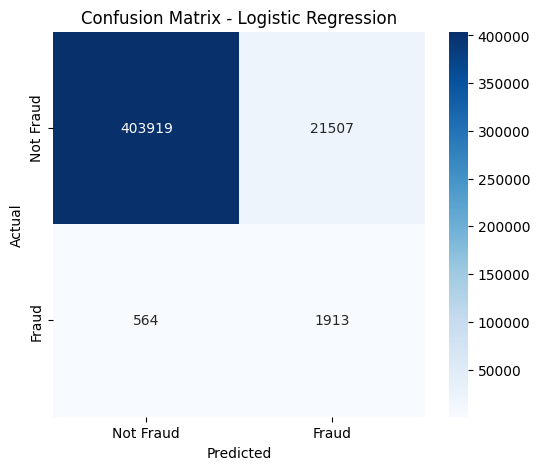

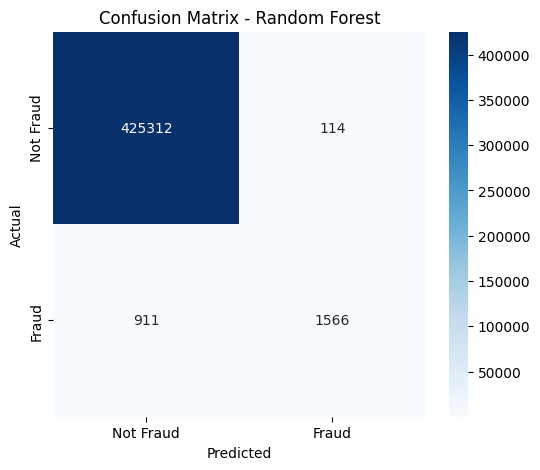

In [24]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

plot_confusion_matrix(y_test, y_test_pred_lr, "Logistic Regression")
plot_confusion_matrix(y_test, y_test_pred_rf, "Random Forest")